In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
from ml_experiments.analyze import get_df_runs_from_mlflow_sql, get_missing_entries, get_common_combinations, get_df_with_combinations
import plotly.express as px
from itertools import product
import time
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Save Results

## Load mlflow runs

In [2]:
db_port = 5003
db_name = 'recursive_clustering'
w = 'clust9'
# url = f'postgresql://{w}.ceremade.dauphine.lan:{db_port}/{db_name}'
url = f'postgresql://belucci@localhost:{db_port}/{db_name}'
engine = create_engine(url)
query = 'SELECT experiments.name from experiments'
experiment_names = pd.read_sql(query, engine)['name'].tolist()
# results_dir = Path('~/tab_benchmark/results')
# os.makedirs(results_dir, exist_ok=True)

In [3]:
experiment_names

['Default',
 'blob_experiment',
 'hpo_classif_experiment',
 'hpo_openml_experiment',
 'hpo_gaussian_experiment',
 'hpo_openml_final',
 'outlier_hc',
 'time_hc']

In [4]:
experiments_names = [
    'outlier_hc',
]

In [5]:
params_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'pct_random',
    'seed_unified',
    'class_sep',
    'n_random',
    'n_informative',
    'n_classes'
]

In [6]:
latest_metrics_columns = [
    'fit_model_return_elapsed_time',
    'max_memory_used',
    'n_clusters_',
    'rand_score',
    'adjusted_rand',
    'mutual_info',
    'adjusted_mutual_info',
    'normalized_mutual_info',
    'homogeneity_completeness_v_measure',
    'silhouette',
    'best_n_clusters_',
    'best_rand_score',
    'best_adjusted_rand',
    'best_mutual_info',
    'best_adjusted_mutual_info',
    'best_normalized_mutual_info',
    'best_homogeneity_completeness_v_measure',
    'best_silhouette',
    'outlier_is_alone',
    'outlier_cluster_count',
    'best_outlier_is_alone',
    'best_outlier_cluster_count',
]

In [7]:
tags_columns = [
    'raised_exception',
    'EXCEPTION',
    'parent_run_id',
    'best_child_run_id',
]

In [8]:
# parameters of each model, they are saved as tags for the parent run
parameters = {
    'RecursiveClustering': ['components_size', 'repetitions', 'kmeans_n_clusters'],
    'KMeans': ['n_clusters'],
    'HDBSCAN': ['min_cluster_size'],
    'DBSCAN': ['eps', 'min_samples'],
    'AffinityPropagation': ['damping'],
    'OPTICS': ['min_samples'],
    'SpectralSubspaceRandomization': ['n_similarities', 'sampling_ratio', 'sc_n_clusters'],
    'WardAgglomerativeClustering': ['n_clusters'],
}
all_model_parameters = [p for model, params in parameters.items() for p in params]
all_model_parameters = list(set(all_model_parameters))
for param in all_model_parameters:
    tags_columns.append(param)

In [9]:
runs_columns = ['run_uuid', 'status', 'start_time', 'end_time']
experiments_columns = []
other_table = 'params'
other_table_keys = params_columns
df_params = get_df_runs_from_mlflow_sql(engine, runs_columns=runs_columns, experiments_columns=experiments_columns, experiments_names=experiments_names, other_table=other_table, other_table_keys=other_table_keys)
df_latest_metrics = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='latest_metrics', other_table_keys=latest_metrics_columns)
df_tags = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='tags', other_table_keys=tags_columns)

In [10]:
df_runs_raw = df_params.join(df_latest_metrics)
df_runs_raw = df_runs_raw.join(df_tags)

In [11]:
df_runs_raw_parents = df_runs_raw.copy()
df_runs_raw_parents = df_runs_raw_parents.loc[df_runs_raw_parents['parent_run_id'].isna()]

In [12]:
df_runs_raw_parents

key,status,start_time,end_time,class_sep,model_nickname,n_classes,n_features,n_informative,n_random,n_samples,...,kmeans_n_clusters,min_cluster_size,min_samples,n_clusters,n_similarities,parent_run_id,raised_exception,repetitions,sampling_ratio,sc_n_clusters
run_uuid,,,,,,,,,,,,,,,,,,,,,
000c326e599d46d9a215f47b5bdeef2d,FINISHED,1737863343404,1737865416953,20.0,WardAgglomerativeClustering,5,10000,None,None,1000,...,NaN,NaN,NaN,5,NaN,NaN,False,NaN,NaN,NaN
01260a6078d740eea549e09dd23ef8bb,FINISHED,1737773428544,1737775139373,20.0,AffinityPropagation,5,1000,None,None,100,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
01468222afa5476fb87eeed59c631e13,FINISHED,1737813741890,1737819165898,30.0,HDBSCAN,5,10000,None,None,1000,...,NaN,5,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
01c50be851c640a0b960f075feb0af37,FINISHED,1737759361181,1737759713835,10.0,RecursiveClustering,5,1000,None,None,100,...,2,NaN,NaN,NaN,NaN,NaN,False,5,NaN,NaN
023d51a6ecb5462584055131ba4ee42f,FINISHED,1737768453896,1737769525956,10.0,WardAgglomerativeClustering,5,1000,None,None,100,...,NaN,NaN,NaN,5,NaN,NaN,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fdce508133a3499a992e6f6143606c8d,FINISHED,1737766372375,1737767691832,20.0,OPTICS,5,1000,None,None,100,...,NaN,NaN,5,NaN,NaN,NaN,False,NaN,NaN,NaN
fe7eb679588a459b9b49766792d39f6d,FINISHED,1737821223122,1737822192044,20.0,KMeans,5,10000,None,None,1000,...,NaN,NaN,NaN,5,NaN,NaN,False,NaN,NaN,NaN
ff1f91c37eca42e29796a8a995488851,FINISHED,1737839687572,1737854843389,20.0,SpectralSubspaceRandomization,5,10000,None,None,1000,...,NaN,NaN,NaN,NaN,13,NaN,False,NaN,0.4110527058030011,5


## Delete duplicate runs (if any) and complete some models that cannot run with some datasets

In [13]:
non_duplicate_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'pct_random',
    'seed_unified',
    'class_sep',
    'n_random',
    'n_informative',
    'n_classes'
]
df_runs_parents = df_runs_raw_parents.dropna(axis=0, how='all', subset=['best_adjusted_rand']).copy()
df_runs_parents = df_runs_parents.loc[(~df_runs_parents.duplicated(non_duplicate_columns))]

# Missing

In [14]:
df_runs_parents['model_nickname'].unique().tolist()

['WardAgglomerativeClustering',
 'AffinityPropagation',
 'HDBSCAN',
 'RecursiveClustering',
 'OPTICS',
 'KMeans',
 'SpectralSubspaceRandomization',
 'DBSCAN']

In [15]:
non_duplicate_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'pct_random',
    'seed_unified',
    'class_sep',
]

In [18]:
# n_samples = ['100', '1000', '10000']
# n_features = ['100', '1000', '10000']
# pct_random = ['0.0', '0.2', '0.5', '0.7']
# seed_unified = [f'{i}' for i in range(10)]
# class_sep = ['10.0', '50.0', '100.0']
n_samples = ['1000']
n_features = ['10000']
pct_random = ['0.0']
seed_unified = [f'{i}' for i in range(10)]
class_sep = ['10.0', '20.0', '30.0']
model_nickname = [
    'WardAgglomerativeClustering',
    'KMeans',
    'DBSCAN',
    'HDBSCAN',
    'SpectralSubspaceRandomization',
    'RecursiveClustering',
    'OPTICS',
    # 'KMeansProj',
    # 'IRFLLRR',
    # 'Clique',
    # 'SingleAgglomerativeClustering',
    # 'SpectralClustering',
    # 'Proclus',
    # 'CompleteAgglomerativeClustering',
    # 'AverageAgglomerativeClustering',
    'AffinityPropagation'
]
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, n_features, pct_random, seed_unified, class_sep]
df_missing = get_missing_entries(df_runs_parents, columns_names, should_contain_values)

In [19]:
df_missing

,model_nickname,n_samples,n_features,pct_random,seed_unified,class_sep


# Get common combinations

In [36]:
model_nickname = [
    'WardAgglomerativeClustering',
    'KMeans',
    'DBSCAN',
    'HDBSCAN',
    'SpectralSubspaceRandomization',
    'RecursiveClustering',
    'OPTICS',
    # 'KMeansProj',
    # 'IRFLLRR',
    # 'Clique',
    # 'SingleAgglomerativeClustering',
    # 'SpectralClustering',
    # 'Proclus',
    # 'CompleteAgglomerativeClustering',
    # 'AverageAgglomerativeClustering',
    'AffinityPropagation'
]
df = df_runs_parents.copy()
df = df.loc[df['model_nickname'].isin(model_nickname)]
column = 'model_nickname'
combination_columns = [
    'n_samples',
    'n_features',
    'pct_random',
    'seed_unified',
    'class_sep',
]
common_combinations = get_common_combinations(df, column, combination_columns)

In [37]:
df_common = get_df_with_combinations(df, combination_columns, common_combinations)

In [38]:
df_common['n_samples'] = df_common['n_samples'].astype(int)
df_common['n_features'] = df_common['n_features'].astype(int)
df_common['pct_random'] = df_common['pct_random'].astype(float)
df_common['class_sep'] = df_common['class_sep'].astype(float)
df_common['seed_unified'] = df_common['seed_unified'].astype(int)
df_common['n_classes'] = df_common['n_classes'].astype(int)
for param in all_model_parameters:
    df_common[param] = df_common[param].astype(float)

In [39]:
df_common

key,status,start_time,end_time,class_sep,model_nickname,n_classes,n_features,n_informative,n_random,n_samples,...,kmeans_n_clusters,min_cluster_size,min_samples,n_clusters,n_similarities,parent_run_id,raised_exception,repetitions,sampling_ratio,sc_n_clusters
run_uuid,,,,,,,,,,,,,,,,,,,,,
01260a6078d740eea549e09dd23ef8bb,FINISHED,1737773428544,1737775139373,20.0,AffinityPropagation,5,1000,None,None,100,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
01c50be851c640a0b960f075feb0af37,FINISHED,1737759361181,1737759713835,10.0,RecursiveClustering,5,1000,None,None,100,...,2.0,NaN,NaN,NaN,NaN,NaN,False,5.0,NaN,NaN
023d51a6ecb5462584055131ba4ee42f,FINISHED,1737768453896,1737769525956,10.0,WardAgglomerativeClustering,5,1000,None,None,100,...,NaN,NaN,NaN,5.0,NaN,NaN,False,NaN,NaN,NaN
028b5cc89054406a9869022f59de3186,FINISHED,1737766360303,1737768193053,30.0,OPTICS,5,1000,None,None,100,...,NaN,NaN,5.0,NaN,NaN,NaN,False,NaN,NaN,NaN
03492e3d47e946bab28d77cbfd4dc139,FINISHED,1737759379381,1737760313267,30.0,RecursiveClustering,5,1000,None,None,100,...,2.0,NaN,NaN,NaN,NaN,NaN,False,8.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fb8a532891a14e0eb52c540d6781454b,FINISHED,1737768422672,1737769042788,10.0,WardAgglomerativeClustering,5,1000,None,None,100,...,NaN,NaN,NaN,5.0,NaN,NaN,False,NaN,NaN,NaN
fc3d7cb076744166933161ca850f4ab8,FINISHED,1737773445131,1737775135446,20.0,AffinityPropagation,5,1000,None,None,100,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
fdce508133a3499a992e6f6143606c8d,FINISHED,1737766372375,1737767691832,20.0,OPTICS,5,1000,None,None,100,...,NaN,NaN,5.0,NaN,NaN,NaN,False,NaN,NaN,NaN


# Plots

In [42]:
df = df_common.copy()
df = df.loc[df['n_samples'] == 100]
df = df.loc[df['n_features'] == 1000]
df = df.loc[df['pct_random'] == 0.0]
df = df[['model_nickname', 'class_sep', 'best_outlier_is_alone', 'best_outlier_cluster_count', 'best_n_clusters_']]
df = df.sort_values(['class_sep', 'model_nickname'])

In [43]:
df

key,model_nickname,class_sep,best_outlier_is_alone,best_outlier_cluster_count,best_n_clusters_
run_uuid,,,,,
26e80c5d96b8459ea0715954efe2353b,AffinityPropagation,10.0,0.0,21.0,5.0
27cb6bb93cc840189d72da03c707a083,AffinityPropagation,10.0,0.0,10.0,6.0
3c021fa1fdea4496b7bddcb82a7cef2f,AffinityPropagation,10.0,0.0,21.0,5.0
44e08feb79bc4c02afe0f887a15c45e4,AffinityPropagation,10.0,0.0,12.0,6.0
68a0325980f14fd88d04147cab5c12f3,AffinityPropagation,10.0,0.0,21.0,5.0
...,...,...,...,...,...
9f7deb0a207f4581b1a3445aa5d39162,WardAgglomerativeClustering,30.0,1.0,1.0,6.0
abc8d8e7d1bb4603b13024dbbb1e46cf,WardAgglomerativeClustering,30.0,1.0,1.0,6.0
df2e5a9df83f4808a181e0348b73f958,WardAgglomerativeClustering,30.0,1.0,1.0,6.0


In [ ]:
parameters = {
    'RecursiveClustering': ['components_size', 'repetitions', 'kmeans_n_clusters'],
    'KMeans': ['n_clusters'],
    'HDBSCAN': ['min_cluster_size'],
    'DBSCAN': ['eps', 'min_samples'],
    'AffinityPropagation': ['damping'],
    'OPTICS': ['min_samples'],
    'SpectralSubspaceRandomization': ['n_similarities', 'sampling_ratio', 'sc_n_clusters'],
    'WardAgglomerativeClustering': ['n_clusters'],
}

In [41]:
df = df_common.copy()
df = df.loc[df['n_samples'] == 1000]
df = df.loc[df['n_features'] == 10000]
df = df.loc[df['pct_random'] == 0.0]
df = df.loc[df['class_sep'] == 50.0]
df = df.sort_values('model_nickname')
fig = px.box(df, x='model_nickname', y='best_adjusted_rand', color='model_nickname')
fig.show()

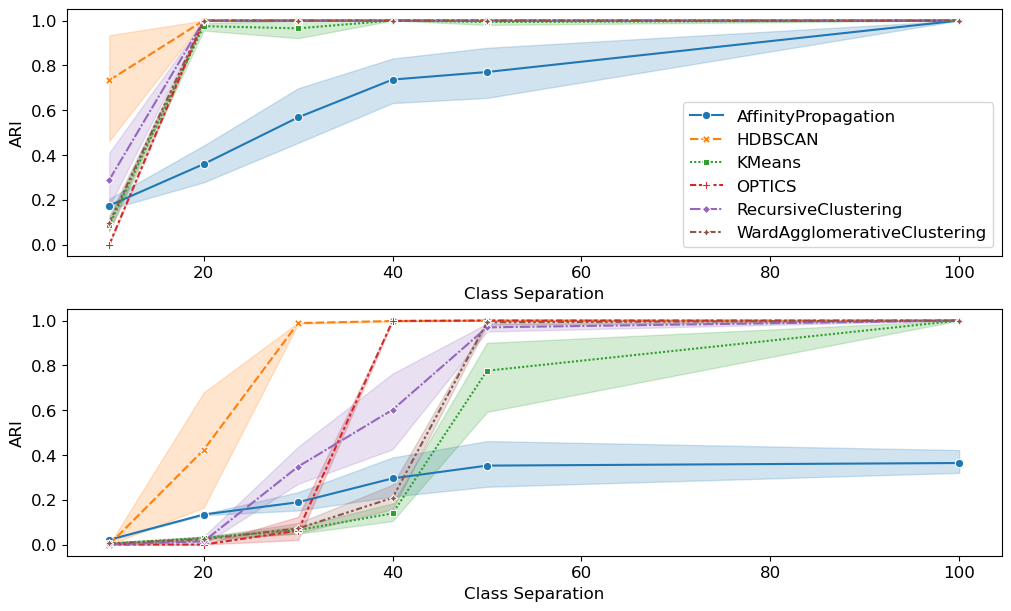

In [72]:
df = df_common.copy()
# n_features = 1000
# n_samples = 1000
n_samples_n_features = [(1000, 1000), (1000, 10000)]
pct_random = 0.0
df = df.loc[df['pct_random']==pct_random]
df = df.loc[df['model_nickname'].isin(['RecursiveClustering', 'KMeans', 'HDBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df = df.sort_values(by='model_nickname')
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples', 'n_features': 'Number of features', 'model_nickname': 'Model', 'class_sep': 'Class Separation', 'pct_random': '% Random Features', 'best_adjusted_rand' : 'ARI'})
plt.style.use('default')
# plt.style.use('seaborn-v0_8-paper')
with mpl.rc_context(rc={
    'figure.constrained_layout.use': True, 
    'savefig.bbox': 'tight', 
    'figure.figsize': (10, 6),
    'legend.loc': 'upper left',
    'legend.frameon': False,
    'font.size': 12,
    # 'font.family': 'serif',
    # 'font.serif': 'Times',
    'text.color': 'black',
    'grid.color': 'black',
    'grid.alpha': 0.5,
}):
    fig, axs = plt.subplots(2, 1)
    axs = axs.flatten()
    for i, (n_samples, n_features) in enumerate(n_samples_n_features):
        df_plot = df.copy()
        df_plot = df_plot.loc[df_plot['Number of features']==n_features]
        df_plot = df_plot.loc[df_plot['Number of samples']==n_samples]
        ax = sns.lineplot(data=df_plot, x='Class Separation', y='ARI', hue='Model', style='Model', markers=True, errorbar='ci', ax=axs[i])
        ax.legend().set_visible(False)
        # plt.legend(title=None, bbox_to_anchor=(0.6, 0.3))
        # plt.savefig(f'hypercube_n-samples{n_samples}_n-features{n_features}_pct-random{pct_random}.pdf')
        # plt.show()
axs[0].legend(title=None, fontsize=12)
plt.savefig(f'hypercube_n-samples-n-features{n_samples_n_features}_pct-random{pct_random}.pdf')
plt.show()

In [126]:
df = df_common.copy()
df = df.loc[df['n_samples'] == 1000]
df = df.loc[df['n_features'] == 1000]
# df = df.loc[df['pct_random'] == 0.7]
df = df.loc[df['class_sep'] == 100.0]
df = df.loc[df['model_nickname'].isin(['RecursiveClustering', 'KMeans', 'HDBSCAN', 'DBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df = df.sort_values('model_nickname')
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples', 'n_features': 'Number of features', 'model_nickname': 'Model', 'best_adjusted_rand': 'Adjusted Rand', 'best_n_clusters_': 'Number of Clusters Found', 'n_classes': 'True Number of Clusters', 'class_sep': 'Class Separation', 'pct_random': '% Random Features', 'seed_unified': 'Seed'})
df = df[['Model', 'Adjusted Rand', 'Time (s)', 'Memory (MB)', 'Number of samples', 'Number of features', 'Class Separation', '% Random Features', 'Seed', 'Number of Clusters Found', 'True Number of Clusters']]
df = df.groupby('Model').agg({'Adjusted Rand': ['mean', 'std'], 'Number of Clusters Found': ['median', ('Q25', lambda x: x.quantile(0.25)), ('Q75', lambda x: x.quantile(0.75))], 'Time (s)': ['mean', 'std'], 'Memory (MB)': ['mean', 'std'], 'Number of samples': ['mean', 'nunique'], 'Number of features': ['mean', 'nunique'], 'Class Separation': ['mean', 'nunique'], '% Random Features': ['mean', 'nunique'], 'True Number of Clusters': ['mean', 'nunique'], 'Seed': ['mean', 'nunique']})
df.to_csv('simulated_data_easy.csv')
df

key                           Adjusted Rand      Number of Clusters Found  \
                                       mean  std                   median   
Model                                                                       
AffinityPropagation                     1.0  0.0                      5.0   
DBSCAN                                  0.0  0.0                      1.0   
HDBSCAN                                 1.0  0.0                      5.0   
KMeans                                  1.0  0.0                      5.0   
OPTICS                                  1.0  0.0                      5.0   
RecursiveClustering                     1.0  0.0                      5.0   
SpectralSubspaceRandomization           1.0  0.0                      5.0   
WardAgglomerativeClustering             1.0  0.0                      5.0   

key                                         Time (s)             Memory (MB)  \
                               Q25  Q75         mean         std        mean   
Model                                                                          
AffinityPropagation            5.0  5.0   537.226421   39.111352   2059.4429   
DBSCAN                         1.0  1.0   495.724737   24.503844   2034.5569   
HDBSCAN                        5.0  5.0   156.379071   16.678345   1951.1594   
KMeans                         5.0  5.0   455.211977   39.756185   2024.6738   
OPTICS                         5.0  5.0   186.481377   12.323363   2067.3815   
RecursiveClustering            5.0  5.0  2264.785293  217.413369   2080.0290   
SpectralSubspaceRandomization  5.0  5.0  3496.919557  733.693875   1108.6247   
WardAgglomerativeClustering    5.0  5.0   267.337123   30.720733   2059.1330   

key                                       Number of samples  ...  \
                                      std              mean  ...   
Model                                                        ...   
AffinityPropagation              1.779558            1000.0  ...   
DBSCAN                           1.282687            1000.0  ...   
HDBSCAN                        228.016285            1000.0  ...   
KMeans                         151.542389            1000.0  ...   
OPTICS                           0.839997            1000.0  ...   
RecursiveClustering              2.354198            1000.0  ...   
SpectralSubspaceRandomization   27.026635            1000.0  ...   
WardAgglomerativeClustering      1.695819            1000.0  ...   

key                           Number of features         Class Separation  \
                                            mean nunique             mean   
Model                                                                       
AffinityPropagation                       1000.0       1            100.0   
DBSCAN                                    1000.0       1            100.0   
HDBSCAN                                   1000.0       1            100.0   
KMeans                                    1000.0       1            100.0   
OPTICS                                    1000.0       1            100.0   
RecursiveClustering                       1000.0       1            100.0   
SpectralSubspaceRandomization             1000.0       1            100.0   
WardAgglomerativeClustering               1000.0       1            100.0   

key                                   % Random Features          \
                              nunique              mean nunique   
Model                                                             
AffinityPropagation                 1              0.35       4   
DBSCAN                              1              0.35       4   
HDBSCAN                             1              0.35       4   
KMeans                              1              0.35       4   
OPTICS                              1              0.35       4   
RecursiveClustering                 1              0.35       4   
SpectralSubspaceRandomization       1              0.35       4   
Ward

In [127]:
df = df_common.copy()
df = df.loc[df['n_samples'] == 1000]
df = df.loc[df['n_features'] == 1000]
df = df.loc[df['pct_random'] == 0.5]
df = df.loc[df['class_sep'] == 10.0]
df = df.loc[df['model_nickname'].isin(['RecursiveClustering', 'KMeans', 'HDBSCAN', 'DBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df = df.sort_values('model_nickname')
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples', 'n_features': 'Number of features', 'model_nickname': 'Model', 'best_adjusted_rand': 'Adjusted Rand', 'best_n_clusters_': 'Number of Clusters Found', 'n_classes': 'True Number of Clusters', 'class_sep': 'Class Separation', 'pct_random': '% Random Features', 'seed_unified': 'Seed'})
df = df[['Model', 'Adjusted Rand', 'Time (s)', 'Memory (MB)', 'Number of samples', 'Number of features', 'Class Separation', '% Random Features', 'Seed', 'Number of Clusters Found', 'True Number of Clusters']]
df = df.groupby('Model').agg({'Adjusted Rand': ['mean', 'std'], 'Number of Clusters Found': ['median', ('Q25', lambda x: x.quantile(0.25)), ('Q75', lambda x: x.quantile(0.75))], 'Time (s)': ['mean', 'std'], 'Memory (MB)': ['mean', 'std'], 'Number of samples': ['mean', 'nunique'], 'Number of features': ['mean', 'nunique'], 'Class Separation': ['mean', 'nunique'], '% Random Features': ['mean', 'nunique'], 'True Number of Clusters': ['mean', 'nunique'], 'Seed': ['mean', 'nunique']})
df.to_csv('simulated_data_hard.csv')
df

key                           Adjusted Rand            \
                                       mean       std   
Model                                                   
AffinityPropagation                0.189093  0.017298   
DBSCAN                             0.000000  0.000000   
HDBSCAN                            0.993713  0.003036   
KMeans                             0.200988  0.060978   
OPTICS                             0.399327  0.344323   
RecursiveClustering                0.433655  0.230195   
SpectralSubspaceRandomization      0.915287  0.202475   
WardAgglomerativeClustering        0.494884  0.296377   

key                           Number of Clusters Found              \
                                                median  Q25    Q75   
Model                                                                
AffinityPropagation                               21.5  2.0  42.00   
DBSCAN                                             1.0  1.0   1.00   
HDBSCAN                                            6.0  6.0   6.00   
KMeans                                             2.0  2.0   2.00   
OPTICS                                             2.5  2.0   4.50   
RecursiveClustering                                4.0  3.0   4.75   
SpectralSubspaceRandomization                      5.0  5.0   5.00   
WardAgglomerativeClustering                        2.0  2.0   4.25   

key                               Time (s)             Memory (MB)  \
                                      mean         std        mean   
Model                                                                
AffinityPropagation             529.730182   10.693666   2059.4900   
DBSCAN                          478.425069    8.144741   2034.9944   
HDBSCAN                         157.498777    5.076115   2008.3772   
KMeans                          421.863799   23.231615   2065.8152   
OPTICS                          193.670200    4.669891   2067.3468   
RecursiveClustering            2390.756949  168.434082   2078.1840   
SpectralSubspaceRandomization  3650.157271  473.980725   1103.1100   
WardAgglomerativeClustering     250.402186   13.845500   2058.1964   

key                                       Number of samples  ...  \
                                      std              mean  ...   
Model                                                        ...   
AffinityPropagation              2.024502            1000.0  ...   
DBSCAN                           1.190787            1000.0  ...   
HDBSCAN                        178.319054            1000.0  ...   
KMeans                           4.504178            1000.0  ...   
OPTICS                           1.081793            1000.0  ...   
RecursiveClustering              2.627123            1000.0  ...   
SpectralSubspaceRandomization    4.184572            1000.0  ...   
WardAgglomerativeClustering      2.105722            1000.0  ...   

key                           Number of features         Class Separation  \
                                            mean nunique             mean   
Model                                                                       
AffinityPropagation                       1000.0       1             10.0   
DBSCAN                                    1000.0       1             10.0   
HDBSCAN                                   1000.0       1             10.0   
KMeans                                    1000.0       1             10.0   
OPTICS                                    1000.0       1             10.0   
RecursiveClustering                       1000.0       1             10.0   
SpectralSubspaceRandomization             1000.0       1             10.0   
WardAgglomerativeClustering               1000.0       1             10.0   

key                                   % Random Features          \
                              nunique              mean nunique   
Model                                                             
AffinityPropagation             

# With filling values

In [13]:
non_duplicate_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'pct_random',
    'seed_unified',
    'class_sep',
    'n_random',
    'n_informative',
    'n_classes'
]
df_runs_parents_fill = df_runs_raw_parents.dropna(axis=0, how='all', subset=['best_adjusted_rand']).copy()
df_runs_parents_fill = df_runs_parents_fill.loc[(~df_runs_parents_fill.duplicated(non_duplicate_columns))]

In [14]:
# for the moment, I did not manage to run HDBSCAN and SpectralSubspaceRandomization with samples >= 10000, so we will fill these values for the moment as "no run" and we will see later
status = 'FAILED'
no_run_time = np.inf
no_run_memory = np.inf
no_run_metric = np.nan
raised_exception = True
EXCEPTION = 'NoRun'
start_time = time.time() * 1000
end_time = time.time() * 1000

In [15]:
model_nickname = 'HDBSCAN'
n_samples = ['10000']
n_features = ['100', '1000', '10000']
pct_random = ['0.0', '0.2', '0.5', '0.7']
seed_unified = [f'{i}' for i in range(10)]
class_sep = ['10.0', '100.0', '50.0']
n_classes = 5
combinations = list(product(n_samples, n_features, pct_random, seed_unified, class_sep))
df_cat = []
indexes = []
for n_sample, n_feature, pct_r, seed, class_s in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_classes'] = n_classes
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['pct_random'] = pct_r
    df['seed_unified'] = seed
    df['class_sep'] = class_s
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['best_adjusted_rand'] = no_run_metric
    df['best_n_clusters_'] = no_run_metric
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs_parents_fill = pd.concat([df_runs_parents_fill, df_no_run])

In [16]:
model_nickname = 'SpectralSubspaceRandomization'
n_samples = ['10000']
n_features = ['100', '1000', '10000']
pct_random = ['0.0', '0.2', '0.5', '0.7']
seed_unified = [f'{i}' for i in range(10)]
class_sep = ['10.0', '100.0', '50.0']
n_classes = 5
combinations = list(product(n_samples, n_features, pct_random, seed_unified, class_sep))
df_cat = []
indexes = []
for n_sample, n_feature, pct_r, seed, class_s in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_classes'] = n_classes
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['pct_random'] = pct_r
    df['seed_unified'] = seed
    df['class_sep'] = class_s
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['best_adjusted_rand'] = no_run_metric
    df['best_n_clusters_'] = no_run_metric
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs_parents_fill = pd.concat([df_runs_parents_fill, df_no_run])

In [17]:
# ensure no duplicates
df_runs_parents_fill = df_runs_parents_fill.loc[(~df_runs_parents_fill.duplicated(non_duplicate_columns))]

# Missing

In [28]:
df_runs_parents_fill['model_nickname'].unique().tolist()

['AffinityPropagation',
 'RecursiveClustering',
 'AverageAgglomerativeClustering',
 'HDBSCAN',
 'DBSCAN',
 'KMeansProj',
 'OPTICS',
 'SpectralSubspaceRandomization',
 'Proclus',
 'WardAgglomerativeClustering',
 'KMeans',
 'SingleAgglomerativeClustering',
 'SpectralClustering',
 'CompleteAgglomerativeClustering',
 'IRFLLRR',
 'Clique']

In [29]:
non_duplicate_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'pct_random',
    'seed_unified',
    'class_sep',
]

In [30]:
df_runs_parents_fill

,status,start_time,end_time,class_sep,model_nickname,n_classes,n_features,n_informative,n_random,n_samples,...,max_memory_used,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
000aaf76d56747d59a35d53ba0fde4a4,FINISHED,1.736981e+12,1.736985e+12,50.0,AffinityPropagation,5,10000,2,16,100,...,2000.884,1.609438,10.0,0.837703,0.912525,0.165996,NaN,20b7f8404daf40f0b2c5d0bd9f3730db,NaN,False
000b291a142341289479933ddb447488,FINISHED,1.736872e+12,1.736877e+12,50.0,RecursiveClustering,5,10000,2,16,1000,...,1156.568,1.609438,577.0,0.425927,0.806024,-0.104928,NaN,e62023cb27d941dd8b9683eaef947ccc,NaN,False
000f29a52641434a9a03ec3951ba12ba,FINISHED,1.736890e+12,1.736911e+12,50.0,AverageAgglomerativeClustering,5,10000,2,16,10000,...,1941.040,1.608578,8.0,0.997419,0.999561,0.283838,NaN,8e0a1045c9474ca5925d553aa6030f20,NaN,False
00142f7d57c244c2b33da0cfa8480cbf,FINISHED,1.737110e+12,1.737119e+12,50.0,HDBSCAN,5,10000,2,16,100,...,1982.980,1.609438,5.0,1.000000,1.000000,0.410559,NaN,3196639866e543c0beba6df8434456b6,NaN,False
00151ab7956742b391a46ebbc769a9ff,FINISHED,1.737069e+12,1.737078e+12,50.0,DBSCAN,5,100,2,16,10000,...,1611.760,1.606954,6.0,0.995135,0.999239,0.906276,NaN,830e0db68eb041c1b24fe960ac07e499,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SpectralSubspaceRandomization_10000_10000,FAILED,1.737652e+12,1.737652e+12,100.0,SpectralSubspaceRandomization,5,10000,NaN,NaN,10000,...,inf,NaN,NaN,NaN,NaN,NaN,NoRun,NaN,NaN,True
SpectralSubspaceRandomization_10000_10000,FAILED,1.737652e+12,1.737652e+12,50.0,SpectralSubspaceRandomization,5,10000,NaN,NaN,10000,...,inf,NaN,NaN,NaN,NaN,NaN,NoRun,NaN,NaN,True
SpectralSubspaceRandomization_10000_10000,FAILED,1.737652e+12,1.737652e+12,10.0,SpectralSubspaceRandomization,5,10000,NaN,NaN,10000,...,inf,NaN,NaN,NaN,NaN,NaN,NoRun,NaN,NaN,True
SpectralSubspaceRandomization_10000_10000,FAILED,1.737652e+12,1.737652e+12,100.0,SpectralSubspaceRandomization,5,10000,NaN,NaN,10000,...,inf,NaN,NaN,NaN,NaN,NaN,NoRun,NaN,NaN,True


In [21]:
n_samples = ['1000']
n_features = ['100', '1000', '10000']
pct_random = ['0.0']
seed_unified = [f'{i}' for i in range(5)]
class_sep = ['10.0', '100.0']
model_nickname = [
    # 'KMeansProj',
    # 'IRFLLRR',
    # 'Clique',
    # 'CompleteAgglomerativeClustering',
    # 'AverageAgglomerativeClustering',
    # 'SingleAgglomerativeClustering',
    # 'SpectralClustering',
    # 'Proclus',
    'HDBSCAN',
    'SpectralSubspaceRandomization',
    'RecursiveClustering',
    'OPTICS',
    'WardAgglomerativeClustering',
    'KMeans',
    'DBSCAN',
    'AffinityPropagation'
]
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, n_features, pct_random, seed_unified, class_sep]
df_missing = get_missing_entries(df_runs_parents_fill, columns_names, should_contain_values)

In [22]:
df_missing

,model_nickname,n_samples,n_features,pct_random,seed_unified,class_sep
0,RecursiveClustering,10000,10000,0.5,2,100.0
1,RecursiveClustering,10000,10000,0.5,3,100.0
2,RecursiveClustering,10000,10000,0.5,4,100.0
3,RecursiveClustering,10000,10000,0.7,1,10.0
4,RecursiveClustering,10000,10000,0.7,1,100.0
...,...,...,...,...,...,...
59,AffinityPropagation,10000,10000,0.7,2,100.0
60,AffinityPropagation,10000,10000,0.7,3,10.0
61,AffinityPropagation,10000,10000,0.7,3,100.0
62,AffinityPropagation,10000,10000,0.7,4,10.0


# Get common combinations

In [23]:
model_nickname = [
    # 'KMeansProj',
    # 'IRFLLRR',
    # 'Clique',
    # 'CompleteAgglomerativeClustering',
    # 'AverageAgglomerativeClustering',
    # 'SingleAgglomerativeClustering',
    # 'SpectralClustering',
    # 'Proclus',
    'HDBSCAN',
    'SpectralSubspaceRandomization',
    'RecursiveClustering',
    'OPTICS',
    'WardAgglomerativeClustering',
    'KMeans',
    'DBSCAN',
    'AffinityPropagation'
]
df = df_runs_parents_fill.copy()
df = df.loc[df['model_nickname'].isin(model_nickname)]
column = 'model_nickname'
combination_columns = [
    'n_samples',
    'n_features',
    'pct_random',
    'seed_unified',
    'class_sep',
]
common_combinations = get_common_combinations(df, column, combination_columns)

In [24]:
df_common_fill = get_df_with_combinations(df, combination_columns, common_combinations)

In [25]:
df_common_fill['n_samples'] = df_common_fill['n_samples'].astype(int)
df_common_fill['n_features'] = df_common_fill['n_features'].astype(int)
df_common_fill['pct_random'] = df_common_fill['pct_random'].astype(float)
df_common_fill['class_sep'] = df_common_fill['class_sep'].astype(float)
df_common_fill['seed_unified'] = df_common_fill['seed_unified'].astype(int)
df_common_fill['n_classes'] = df_common_fill['n_classes'].astype(int)

## Plot

In [26]:
df_common_fill

,status,start_time,end_time,class_sep,model_nickname,n_classes,n_features,n_informative,n_random,n_samples,...,max_memory_used,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
000aaf76d56747d59a35d53ba0fde4a4,FINISHED,1.736981e+12,1.736985e+12,50.0,AffinityPropagation,5,10000,2,16,100,...,2000.884,1.609438,10.0,0.837703,0.912525,0.165996,NaN,20b7f8404daf40f0b2c5d0bd9f3730db,NaN,False
000b291a142341289479933ddb447488,FINISHED,1.736872e+12,1.736877e+12,50.0,RecursiveClustering,5,10000,2,16,1000,...,1156.568,1.609438,577.0,0.425927,0.806024,-0.104928,NaN,e62023cb27d941dd8b9683eaef947ccc,NaN,False
00142f7d57c244c2b33da0cfa8480cbf,FINISHED,1.737110e+12,1.737119e+12,50.0,HDBSCAN,5,10000,2,16,100,...,1982.980,1.609438,5.0,1.000000,1.000000,0.410559,NaN,3196639866e543c0beba6df8434456b6,NaN,False
0018167e4ff1486a8a909f25fdaa5d76,FINISHED,1.734289e+12,1.734364e+12,100.0,RecursiveClustering,5,100,2,16,1000,...,2077.516,1.609438,5.0,1.000000,1.000000,0.936638,NaN,0fc46cf1ca434f86841b195a2b92e37d,NaN,False
00187fd8f9df4282ba536e067e9b6881,FINISHED,1.736687e+12,1.736691e+12,100.0,HDBSCAN,5,100,2,16,10000,...,1212.672,1.609438,5.0,1.000000,1.000000,0.939268,NaN,c25dc85141e84c21b389b9e9cfced842,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SpectralSubspaceRandomization_10000_10000,FAILED,1.737652e+12,1.737652e+12,100.0,SpectralSubspaceRandomization,5,10000,NaN,NaN,10000,...,inf,NaN,NaN,NaN,NaN,NaN,NoRun,NaN,NaN,True
SpectralSubspaceRandomization_10000_10000,FAILED,1.737652e+12,1.737652e+12,50.0,SpectralSubspaceRandomization,5,10000,NaN,NaN,10000,...,inf,NaN,NaN,NaN,NaN,NaN,NoRun,NaN,NaN,True
SpectralSubspaceRandomization_10000_10000,FAILED,1.737652e+12,1.737652e+12,10.0,SpectralSubspaceRandomization,5,10000,NaN,NaN,10000,...,inf,NaN,NaN,NaN,NaN,NaN,NoRun,NaN,NaN,True
SpectralSubspaceRandomization_10000_10000,FAILED,1.737652e+12,1.737652e+12,100.0,SpectralSubspaceRandomization,5,10000,NaN,NaN,10000,...,inf,NaN,NaN,NaN,NaN,NaN,NoRun,NaN,NaN,True


In [111]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


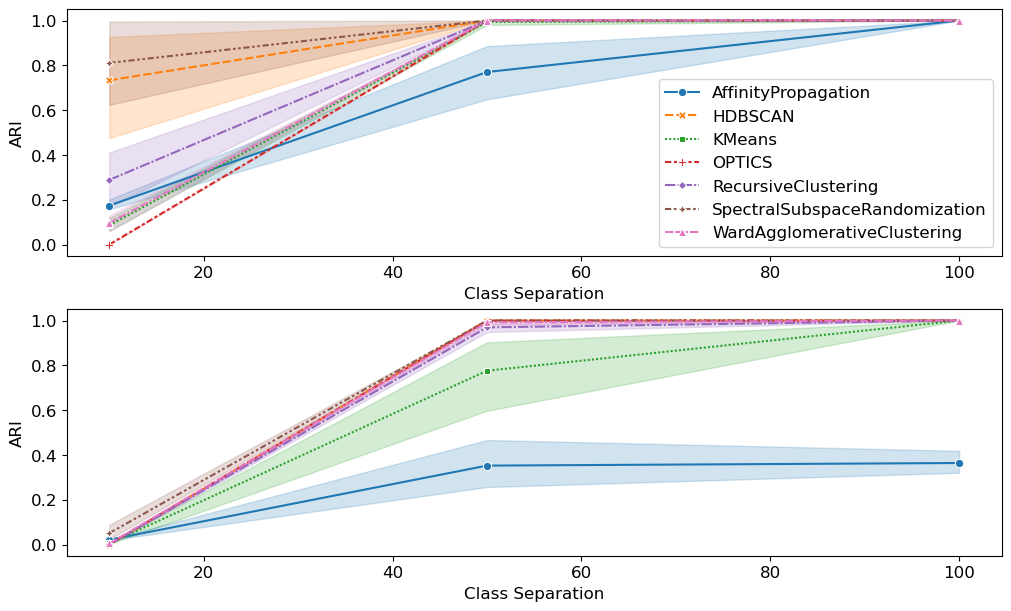

In [174]:
df = df_common_fill.copy()
# n_features = 1000
# n_samples = 1000
n_samples_n_features = [(1000, 1000), (1000, 10000)]
pct_random = 0.0
df = df.loc[df['pct_random']==pct_random]
df = df.loc[df['model_nickname'].isin(['RecursiveClustering', 'KMeans', 'HDBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df = df.sort_values(by='model_nickname')
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples', 'n_features': 'Number of features', 'model_nickname': 'Model', 'class_sep': 'Class Separation', 'pct_random': '% Random Features', 'best_adjusted_rand' : 'ARI'})
plt.style.use('default')
# plt.style.use('seaborn-v0_8-paper')
with mpl.rc_context(rc={
    'figure.constrained_layout.use': True, 
    'savefig.bbox': 'tight', 
    'figure.figsize': (10, 6),
    'legend.loc': 'upper left',
    'legend.frameon': False,
    'font.size': 12,
    # 'font.family': 'serif',
    # 'font.serif': 'Times',
    'text.color': 'black',
    'grid.color': 'black',
    'grid.alpha': 0.5,
}):
    fig, axs = plt.subplots(2, 1)
    axs = axs.flatten()
    for i, (n_samples, n_features) in enumerate(n_samples_n_features):
        df_plot = df.copy()
        df_plot = df_plot.loc[df_plot['Number of features']==n_features]
        df_plot = df_plot.loc[df_plot['Number of samples']==n_samples]
        ax = sns.lineplot(data=df_plot, x='Class Separation', y='ARI', hue='Model', style='Model', markers=True, errorbar='ci', ax=axs[i])
        ax.legend().set_visible(False)
        # plt.legend(title=None, bbox_to_anchor=(0.6, 0.3))
        # plt.savefig(f'hypercube_n-samples{n_samples}_n-features{n_features}_pct-random{pct_random}.pdf')
        # plt.show()
axs[0].legend(title=None, fontsize=12)
plt.savefig(f'hypercube_n-samples-n-features{n_samples_n_features}_pct-random{pct_random}.pdf')
plt.show()

In [145]:
axs

array([<Axes: xlabel='Class Separation', ylabel='ARI'>,
       <Axes: xlabel='Class Separation', ylabel='ARI'>], dtype=object)

In [32]:
df

,status,start_time,end_time,Class Separation,Model,n_classes,Number of features,n_informative,n_random,Number of samples,...,Memory (MB),mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
00434965d9e742dab4fca07ff6620553,FINISHED,1.734291e+12,1.734316e+12,10.0,KMeans,5,1000,2,16,1000,...,2067.632,1.405668,28.0,0.574649,0.832869,0.048877,NaN,10c39f4292ae418cbb2ca6f3725c6fc5,NaN,False
024ee88370de4bee82dd88335f0c5552,FINISHED,1.734291e+12,1.734381e+12,10.0,RecursiveClustering,5,1000,2,16,1000,...,2081.452,0.299602,4.0,0.252011,0.540775,-0.039293,NaN,f86475c0347f4165a64e38322bd09799,NaN,False
0a00eaeeeb804b758d57a926ae840a02,FINISHED,1.734289e+12,1.734307e+12,10.0,DBSCAN,5,1000,2,16,1000,...,2032.656,0.000000,1.0,0.000000,0.199199,-1.000000,NaN,e39a836121cd4a3abb33ecd5067a05c8,NaN,False
0bfcda2705694c7b9f11c2bc3890e4cd,FINISHED,1.734291e+12,1.734382e+12,10.0,RecursiveClustering,5,1000,2,16,1000,...,2081.756,1.105349,8.0,0.645402,0.897688,0.007890,NaN,f209f5a1528142b6904e1684d3b84352,NaN,False
10312d33d94b4e1d82d9167b3098342b,FINISHED,1.734291e+12,1.734316e+12,10.0,KMeans,5,1000,2,16,1000,...,2057.660,0.416453,7.0,0.235449,0.757640,0.066329,NaN,5271233361824052a11dc989f98f65c0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f1d02f9c10b9423bb9a7fbfc92e30900,FINISHED,1.734291e+12,1.734301e+12,100.0,OPTICS,5,1000,2,16,1000,...,2067.152,1.609438,5.0,1.000000,1.000000,0.801480,NaN,7801d6e430754157b01e6bf6af016ced,NaN,False
fabcb033387247649d6b11741d1a12ad,FINISHED,1.734290e+12,1.734300e+12,100.0,HDBSCAN,5,1000,2,16,1000,...,1500.880,1.609438,5.0,1.000000,1.000000,0.796554,NaN,daa89c07e0b64937947893455edafb8f,NaN,False
f848acc1dd904a34820daefbf05026bc,FINISHED,1.734290e+12,1.734301e+12,100.0,HDBSCAN,5,1000,2,16,1000,...,2063.232,1.609438,5.0,1.000000,1.000000,0.780627,NaN,25a2979e179e4b2ea6d85571e8a64ffb,NaN,False
f29b69324a8748449a54aeb6f60eca47,FINISHED,1.734291e+12,1.734317e+12,100.0,KMeans,5,1000,2,16,1000,...,2068.528,1.609438,10.0,0.838447,0.916224,0.256958,NaN,c50559b555874c50a04751b63546a2cb,NaN,False


In [39]:
df = df[['model_nickname', 'best_adjusted_rand']]

In [41]:
print(df)

                                       model_nickname  best_adjusted_rand
00434965d9e742dab4fca07ff6620553               KMeans            0.073381
024ee88370de4bee82dd88335f0c5552  RecursiveClustering            0.532897
0579ed873a634a14ae7337807c3e70c1               OPTICS            1.000000
06ab20f56b1b4474922675ae8e71edd2               DBSCAN            0.000000
0721a299f8dd4c7daa180275f6af4016               OPTICS            1.000000
...                                               ...                 ...
fe45783035044fdb8f6933fc4b795818               OPTICS            1.000000
fe6d169bc59d4a18a570ed1b22c0a275  RecursiveClustering            0.000016
fe8416665ea343d4863ecea4fc027d86              HDBSCAN            0.952232
fe92c730ca1b478e8a3b642fb2d964a5               DBSCAN            0.000000
ffbea3f03bf94cb89131832f6d2df628               KMeans            0.075772

[240 rows x 2 columns]


In [36]:
df = df_common_fill.copy()
n_features = 1000
n_samples = 1000
pct_random = 0.0
df = df.loc[df['n_features']==n_features]
df = df.loc[df['n_samples']==n_samples]
df = df.loc[df['pct_random']==pct_random]
df = df.loc[df['model_nickname'].isin(['RecursiveClustering', 'KMeans', 'HDBSCAN', 'DBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df = df.sort_values(by='class_sep')
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples', 'n_features': 'Number of features', 'model_nickname': 'Model', 'class_sep': 'Class Separation', 'pct_random': '% Random Features', 'best_adjusted_rand' : 'ARI'})
fig = px.line(df, x='Class Separation', y='ARI', color='Model', template='presentation', line_dash='Model', markers=True,
              category_orders={'Model': ['RecursiveClustering', 'KMeans', 'HDBSCAN', 'DBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering']})
# # transparent background
fig.update_layout({
    'font': {
        'color': 'black',
        'size': 15
    },
    'xaxis': {
        'color': 'black',
        'title': {'standoff': 15},
    }, 
    'yaxis': {
        'color': 'black',
    },
    'margin': {
        't': 10,
        'b': 50,
        'l': 50,
        'r': 30,
    },
    'legend': {
        'orientation': 'h',
        'yanchor': 'bottom',
        'y': 1.02,
        'xanchor': 'left',
        'x': 0.01,
        'title': {'text': ''}
    }
})
# fig.update_xaxes(showline=True, mirror=True, dtick='D2')
# fig.update_yaxes(showline=True, mirror=True, dtick='D2')
fig.show()
fig.write_image(f'time_n-samples_n-features{n_features}.pdf')

In [27]:
df

,status,start_time,end_time,Class Separation,Model,n_classes,Number of features,n_informative,n_random,Number of samples,...,Memory (MB),mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,EXCEPTION,best_child_run_id,parent_run_id,raised_exception


In [ ]:
df = df_common_fill.copy()
df = df.loc[df['n_samples'] == 10000]
df = df.loc[df['n_features'] == 10000]
# df = df.loc[df['pct_random'] == 0.5]
df = df.loc[df['class_sep'] == 50.0]
df = df.sort_values('model_nickname')
fig = px.box(df, x='model_nickname', y='best_adjusted_rand', color='model_nickname')
fig.show()

In [40]:
df = df_common_fill.copy()
df = df.loc[df['model_nickname'].isin(['RecursiveClustering', 'KMeans', 'HDBSCAN', 'DBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df['Config.'] = '\parbox{1.5cm}{l=' + df['class_sep'].astype(str) + '; n=' + df['n_samples'].astype(str) + '; p=' + df['n_features'].astype(str) + '; r=' + df['pct_random'].astype(str) + ';}'
df = df.rename(columns={'model_nickname': 'Model'})
df = df.groupby(['Config.', 'Model']).agg({'best_adjusted_rand': ['mean', 'std'], 'fit_model_return_elapsed_time': ['mean', 'std'], 'max_memory_used': ['mean', 'std'], 'seed_unified': 'count', 'class_sep': 'first', 'n_samples': 'first', 'n_features': 'first', 'pct_random': 'first'})
df = df.sort_values([('class_sep', 'first'), ('n_samples', 'first'), ('n_features', 'first'), ('pct_random', 'first')])
df = df[['best_adjusted_rand']]
df = df.rename(columns={'best_adjusted_rand': 'ARI'})
# df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples', 'n_features': 'Number of features', 'model_nickname': 'Model', 'best_adjusted_rand': 'Adjusted Rand', 'best_n_clusters_': 'Number of Clusters Found', 'n_classes': 'True Number of Clusters', 'class_sep': 'Class Separation', 'pct_random': '% Random Features', 'seed_unified': 'Seed'})
# df = df[['Model', 'Adjusted Rand', 'Time (s)', 'Memory (MB)', 'Number of samples', 'Number of features', 'Class Separation', '% Random Features', 'Seed', 'Number of Clusters Found', 'True Number of Clusters']]
# df = df.groupby('Model').agg({'Adjusted Rand': ['mean', 'std'], 'Number of Clusters Found': ['median', ('Q25', lambda x: x.quantile(0.25)), ('Q75', lambda x: x.quantile(0.75))], 'Time (s)': ['mean', 'std'], 'Memory (MB)': ['mean', 'std'], 'Number of samples': ['mean', 'nunique'], 'Number of features': ['mean', 'nunique'], 'Class Separation': ['mean', 'nunique'], '% Random Features': ['mean', 'nunique'], 'True Number of Clusters': ['mean', 'nunique'], 'Seed': ['mean', 'nunique']})
# df.to_csv('simulated_data_easy_more_samples.csv')
# df

In [167]:
# "interesting cases"
# easy: 1000 samples, 1000 features, x random, 100 class sep
# easy more samples: 10000 samples, 10000 features, x random, 100 class sep
# hard: 1000 samples, 1000 features, x random, 10 class sep
# hard more samples: 10000 samples, 1000 features, x random, 10 class sep
# medium: x samples, 10000 features, x random, 50 class sep

df = df_common_fill.copy()
# df = df.loc[df['n_samples'] == 10000]
# df = df.loc[df['n_features'] == 10000]
# df = df.loc[df['pct_random'] == 0.5]
# df = df.loc[df['class_sep'] == 100.0]
df = df.loc[df['model_nickname'].isin(['RecursiveClustering', 'KMeans', 'HDBSCAN', 'DBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df['Config.'] = '\parbox{1.5cm}{l=' + df['class_sep'].astype(str) + '; n=' + df['n_samples'].astype(str) + '; p=' + df['n_features'].astype(str) + '; r=' + df['pct_random'].astype(str) + ';}'
df = df.rename(columns={'model_nickname': 'Model'})
df = df.groupby(['Config.', 'Model']).agg({'best_adjusted_rand': ['mean', 'std'], 'fit_model_return_elapsed_time': ['mean', 'std'], 'max_memory_used': ['mean', 'std'], 'seed_unified': 'count', 'class_sep': 'first', 'n_samples': 'first', 'n_features': 'first', 'pct_random': 'first'})
df = df.sort_values([('class_sep', 'first'), ('n_samples', 'first'), ('n_features', 'first'), ('pct_random', 'first')])
df = df.rename(columns={'best_adjusted_rand': 'ARI'})
# easy = 1000 samples, 1000 features, x random, 100 class sep
df_easy = df.loc[(df[('n_samples', 'first')] == 1000) & (df[('n_features', 'first')] == 1000) & (df[('class_sep', 'first')] == 100.0) 
                 & (df[('pct_random', 'first')] == 0.0)].copy()
df_easy = df_easy[['ARI']]
# easy more samples = 10000 samples, 10000 features, x random, 100 class sep
df_easy_more_samples = df.loc[(df[('n_samples', 'first')] == 10000) & (df[('n_features', 'first')] == 10000) & (df[('class_sep', 'first')] == 100.0)
                               & (df[('pct_random', 'first')] == 0.0)].copy()
df_easy_more_samples = df_easy_more_samples[['ARI']]
# hard = 1000 samples, 1000 features, x random, 10 class sep
df_hard = df.loc[(df[('n_samples', 'first')] == 1000) & (df[('n_features', 'first')] == 1000) & (df[('class_sep', 'first')] == 10.0)].copy()
df_hard = df_hard[['ARI']]
# hard more samples = 10000 samples, 1000 features, x random, 10 class sep
# df_hard_more_samples = df.loc[(df[('n_samples', 'first')] == 10000) & (df[('n_features', 'first')] == 1000) & (df[('class_sep', 'first')] == 10.0)].copy()
# df_hard_more_samples = df_hard_more_samples[['ARI']]
# medium = x samples, 10000 features, x random, 50 class sep
df_medium = df.loc[(df[('n_samples', 'first')] == 100) & (df[('n_features', 'first')] == 10000) & (df[('class_sep', 'first')] == 50.0) & (df[('pct_random', 'first')] == 0.0)].copy()
df_medium = df_medium[['ARI']]

df = pd.concat([df_easy, df_easy_more_samples, df_hard, df_medium], axis=0)

In [168]:
def highlight_max(df):
    max_values = df.groupby(level=0).transform('max')
    is_highlighted = df == max_values
    df_css = df.copy().astype(str)
    df_css.loc[:, :] = ''
    df_css[is_highlighted] = 'font-weight: bold'
    return df_css

In [169]:
print(df.style.apply(highlight_max, subset=[('ARI', 'mean')], axis=None).format(precision=3, na_rep='No Run').to_latex(hrules=True, clines='skip-last;data', convert_css=True))

\begin{tabular}{llrr}
\toprule
 &  & \multicolumn{2}{r}{ARI} \\
 &  & mean & std \\
Config. & Model &  &  \\
\midrule
\multirow[c]{8}{*}{\parbox{1.5cm}{l=100.0; n=1000; p=1000; r=0.0;}} & AffinityPropagation & \bfseries 1.000 & 0.000 \\
 & DBSCAN & 0.000 & 0.000 \\
 & HDBSCAN & \bfseries 1.000 & 0.000 \\
 & KMeans & \bfseries 1.000 & 0.000 \\
 & OPTICS & \bfseries 1.000 & 0.000 \\
 & RecursiveClustering & \bfseries 1.000 & 0.000 \\
 & SpectralSubspaceRandomization & \bfseries 1.000 & 0.000 \\
 & WardAgglomerativeClustering & \bfseries 1.000 & 0.000 \\
\cline{1-4}
\multirow[c]{8}{*}{\parbox{1.5cm}{l=100.0; n=10000; p=10000; r=0.0;}} & AffinityPropagation & 0.115 & No Run \\
 & DBSCAN & 0.000 & No Run \\
 & HDBSCAN & No Run & No Run \\
 & KMeans & \bfseries 1.000 & No Run \\
 & OPTICS & \bfseries 1.000 & No Run \\
 & RecursiveClustering & \bfseries 1.000 & No Run \\
 & SpectralSubspaceRandomization & No Run & No Run \\
 & WardAgglomerativeClustering & 0.783 & No Run \\
\cline{1-4}
\multi

In [63]:
with pd.option_context('display.max_colwidth', None):
    display(df.style.highlight_max(subset=[('ARI', 'mean')], axis=0))

ARI  \
                                                                                                                                                            mean   
Config.                                           Model                                                                                                            
\parbox{1.5cm}{l=100.0; n=1000; p=1000; r=0.0;}   AffinityPropagation                     (\parbox{1.5cm}{l=100.0; n=1000; p=1000; r=0.0;}, AffinityPropagation)   
                                                  DBSCAN                                  (\parbox{1.5cm}{l=100.0; n=1000; p=1000; r=0.0;}, AffinityPropagation)   
                                                  HDBSCAN                                 (\parbox{1.5cm}{l=100.0; n=1000; p=1000; r=0.0;}, AffinityPropagation)   
                                                  KMeans                                  (\parbox{1.5cm}{l=100.0; n=1000; p=1000; r=0.0;}, AffinityPropagation)   
                                                  OPTICS                                  (\parbox{1.5cm}{l=100.0; n=1000; p=1000; r=0.0;}, AffinityPropagation)   
                                                  RecursiveClustering                     (\parbox{1.5cm}{l=100.0; n=1000; p=1000; r=0.0;}, AffinityPropagation)   
                                                  SpectralSubspaceRandomization           (\parbox{1.5cm}{l=100.0; n=1000; p=1000; r=0.0;}, AffinityPropagation)   
                                                  WardAgglomerativeClustering             (\parbox{1.5cm}{l=100.0; n=1000; p=1000; r=0.0;}, AffinityPropagation)   
\parbox{1.5cm}{l=100.0; n=10000; p=10000; r=0.0;} AffinityPropagation                                (\parbox{1.5cm}{l=100.0; n=10000; p=10000; r=0.0;}, KMeans)   
                                                  DBSCAN                                             (\parbox{1.5cm}{l=100.0; n=10000; p=10000; r=0.0;}, KMeans)   
                                                  HDBSCAN                                            (\parbox{1.5cm}{l=100.0; n=10000; p=10000; r=0.0;}, KMeans)   
                                                  KMeans                                             (\parbox{1.5cm}{l=100.0; n=10000; p=10000; r=0.0;}, KMeans)   
                                                  OPTICS                                             (\parbox{1.5cm}{l=100.0; n=10000; p=10000; r=0.0;}, KMeans)   
                                                  RecursiveClustering                                (\parbox{1.5cm}{l=100.0; n=10000; p=10000; r=0.0;}, KMeans)   
                                                  SpectralSubspaceRandomization                      (\parbox{1.5cm}{l=100.0; n=10000; p=10000; r=0.0;}, KMeans)   
                                                  WardAgglomerativeClustering                        (\parbox{1.5cm}{l=100.0; n=10000; p=10000; r=0.0;}, KMeans)   
\parbox{1.5cm}{l=10.0; n=1000; p=1000; r=0.0;}    AffinityPropagation            (\parbox{1.5cm}{l=10.0; n=1000; p=1000; r=0.0;}, SpectralSubspaceRandomization)   
                                                  DBSCAN                         (\parbox{1.5cm}{l=10.0; n=1000; p=1000; r=0.0;}, SpectralSubspaceRandomization)   
                                                  HDBSCAN                        (\parbox{1.5cm}{l=10.0; n=1000; p=1000; r=0.0;}, SpectralSubspaceRandomization)   
                                                  KMeans                         (\parbox{1.5cm}{l=10.0; n=1000; p=1000; r=0.0;}, SpectralSubspaceRandomization)   
                                                  OPTICS                         (\parbox{1.5cm}{l=10.0; n=1000; p=1000; r=0.0;}, SpectralSubspaceRandomization)   
                                                  RecursiveClustering            (\parbox{1.5cm}{l=10.0; n=1000; p=1000; r=0.0;}, SpectralSubspaceRandomization)   
                                                  Spectra

# Debug and explore

In [79]:
df = df_runs_raw.copy()
df = df.loc[df['status'] == 'FAILED']

In [78]:
df['EXCEPTION'].unique()

array(['Input X contains NaN.\nSpectralClustering does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values',
       'Empty cluster', 'FunctionTimedOut',
       'index 16 is out of bounds for axis 0 with size 16',
       'index 18 is out of bounds for axis 0 with size 18', nan,
       'SVD did not converge'], dtype=object)

In [42]:
df = df_runs_raw_parents.copy()
df = df.loc[df['status'] == 'FAILED']

In [43]:
df

key,status,start_time,end_time,class_sep,model_nickname,n_classes,n_features,n_informative,n_random,n_samples,...,max_memory_used,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
01f490e163954c9b914d9f9f7765e075,FAILED,1737242580909,1.737260e+12,100.0,RecursiveClustering,5,10000,2,16,10000,...,3631.760,1.609438,7.0,0.920715,0.960011,0.336783,[Errno 28] No space left on device: '/tmp/ea30...,NaN,NaN,True
1185ab831bbc44d1966d666a207215c4,FAILED,1737242168108,1.737260e+12,10.0,RecursiveClustering,5,10000,2,16,10000,...,3345.972,0.793675,2202.0,0.177624,0.799918,-0.216621,RecursiveClustering_0_10000_16_2_10000_0.5_10....,NaN,NaN,True
12c09c8e4f834d15983dc3bdfcbc5959,FAILED,1737241068913,1.737242e+12,50.0,OPTICS,5,100,2,16,10000,...,426.124,NaN,NaN,NaN,NaN,NaN,"Every trial failed, no best model was found",NaN,NaN,True
183f2361e71047adae98f3a64c4174fd,FAILED,1736863645016,1.736865e+12,100.0,HDBSCAN,5,10000,2,16,10000,...,1037.448,NaN,NaN,NaN,NaN,NaN,HDBSCAN_0_10000_16_2_10000_0.7_100.0_0-19785e2...,NaN,NaN,True
27f9e72213b44c04bdb67ef7d2a0e693,FAILED,1737069296874,1.737070e+12,50.0,SpectralSubspaceRandomization,5,100,2,16,10000,...,1042.800,NaN,NaN,NaN,NaN,NaN,SpectralSubspaceRandomization_0_10000_16_2_100...,NaN,NaN,True
2ce22bf1a8c0477b8313a2c021926f17,FAILED,1737242600585,1.737260e+12,100.0,RecursiveClustering,5,10000,2,16,10000,...,3637.124,1.609438,5.0,1.000000,1.000000,0.555884,RecursiveClustering_0_10000_16_2_10000_0.5_100...,NaN,NaN,True
3457a0fa91564368ac3ae4164b12c70d,FAILED,1736863640977,1.736865e+12,10.0,HDBSCAN,5,10000,2,16,10000,...,1038.472,NaN,NaN,NaN,NaN,NaN,HDBSCAN_0_10000_16_2_10000_0.2_10.0_0-b2773806...,NaN,NaN,True
38e1e3deb33b46608f6a5b5b8f99da93,FAILED,1737113267664,1.737181e+12,50.0,SpectralSubspaceRandomization,5,10000,2,16,1000,...,2070.728,1.609438,5.0,1.000000,1.000000,0.401385,SpectralSubspaceRandomization_0_1000_16_2_1000...,NaN,NaN,True
3a54a04f81d0422ca859a7bab8881c8d,FAILED,1736863838482,1.736889e+12,10.0,SingleAgglomerativeClustering,5,10000,2,16,10000,...,1935.216,0.001932,13.0,0.002382,0.201360,0.078242,SingleAgglomerativeClustering_0_10000_16_2_100...,NaN,NaN,True


In [44]:
parent_run_ids = list(df.index)

In [45]:
parent_run_ids

['01f490e163954c9b914d9f9f7765e075',
 '1185ab831bbc44d1966d666a207215c4',
 '12c09c8e4f834d15983dc3bdfcbc5959',
 '183f2361e71047adae98f3a64c4174fd',
 '27f9e72213b44c04bdb67ef7d2a0e693',
 '2ce22bf1a8c0477b8313a2c021926f17',
 '3457a0fa91564368ac3ae4164b12c70d',
 '38e1e3deb33b46608f6a5b5b8f99da93',
 '3a54a04f81d0422ca859a7bab8881c8d',
 '4bb729150a4047e3936c0d62898d819f',
 '4bdc0a18868e4e9f998bf130711d2b23',
 '509a5f91adc24a559c551a67d3176b19',
 '56dfbd80504d4894b7f9346d94379352',
 '584d5567482a47a38b2365e42daaf666',
 '5bfa2e15da68491f91ef0e52658ded1a',
 '63f3db0d9768455891db79bf4f25cb9a',
 '6cb72b4cb1a7484fb07ccb762e2afa60',
 '728eeba9325144af81fcb3e61779f67c',
 '734c393283594d0580c681ee480ea77f',
 '83386e96e53347d6b0a94a650638ebe0',
 '87afb3a0102f478b9e93789ceb9c765b',
 '8f7ca2c7f3824f80895636f6e4ffc224',
 '91aef0d462cf41e98c8158b9a2cf3d60',
 'a509fded18e34b2db012ad900a8ea33d',
 'aa7a22cb6c2544a99f93fef9ad998812',
 'ac5535d9dab64e0984f05e4781878211',
 'ae9e3db12a3841b4a6b7d7cc99a8175e',
 

In [46]:
df = df_runs_raw.copy()
df = df.loc[df['parent_run_id'].isin(parent_run_ids)]

In [82]:
child_run_ids = list(df.index)

In [83]:
runs_to_delete = child_run_ids

In [84]:
print(runs_to_delete, len(runs_to_delete))

['0000c6d69e0f4e85b8d1650b58da14f2', '0000da5f9fc24a569b9ffb8b8432f437', '000206dcb44b4b91a3e4b9e14c6ca91d', '000235a40393424b9eec5ae38d3c5df9', '00027203bf6240759b5c94c2a71df7e2', '00049fb232ea4abcacd62d7fd1b9a984', '000b9da051974b9f9a629569bf067175', '000f3ca3f9ba4d0a9b0a2337d3acefb9', '0010a7237b3b4aa08ed0a5108b3aeac3', '0012082c59754f679754ad74e8770c03', '00139e746ec040a58d7b18bc45ec5b9b', '00199a61ac8049719568c2d2d3f3ef76', '001ded53b30142399200ae03e96dc164', '001f9f0c3804485ea40ddf7c648e1656', '002058b02b3a431fac0e2479a4819986', '0022adbe04484660af3908bfa5356221', '0024617690814b169201c319c7cc4b8f', '002599d25ba64c83a75d96fb6f8ef4ba', '002679b28ce4407ebaa5f4dd4d320feb', '0026de99ef744795b7debe8634055f65', '00289663864d47bd89a0f30684d3d0cf', '0030f0faf01943a6bb82d7739f1f0043', '00318479d22d425f9e63eef277a28167', '003646d80ffd4949bf7bf814f8ad6b6f', '00367ceaee50474b831ddf75a38ebf01', '003fab528dc64ac8ba585942a4fdb421', '00407135dda44c76ad763fa046180e05', '0041650e45e54ef8a33c302d1e

In [85]:
run_uuid_query = [f"'{run_id}'" for run_id in runs_to_delete]
run_uuid_query = ', '.join(run_uuid_query)

In [86]:
query = f"""
UPDATE runs
SET lifecycle_stage = 'deleted'
WHERE run_uuid IN ({run_uuid_query}) 
"""
with engine.begin() as conn:
    conn.execute(text(query))

for i, row in df_runs_raw.iterrows():
    run_id = row.run_id
    model_name = row['params.model_name']
    with mlflow.start_run(run_id) as run:
        mlflow.log_param('model_nickname', model_name)    